In [1]:
from model import BiSeNet

import torch
import matplotlib.pyplot as plt
import os
import os.path as osp
import sys
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2


sys.path.append(os.path.dirname(sys.path[0]))
sys.path.append(os.path.dirname(sys.path[0]))

In [2]:

def vis_parsing_maps(im, parsing_anno, stride, save_im=False, save_path='vis_results/parsing_map_on_im.jpg'):
    # Colors for all 20 parts
    part_colors = [[255, 125, 125], [215, 235, 255], [50, 65, 225],
                   [0, 140, 255], [0, 252, 124],
                   [167, 108, 188], [66, 71, 147], [170, 255, 0],
                   [19, 69, 139], [0, 255, 170],
                   [0, 0, 255], [85, 219, 236], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = np.max(vis_parsing_anno)

    for pi in range(0, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    # print(vis_parsing_anno_color.shape, vis_im.shape)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.5, vis_parsing_anno_color, 0.5, 0)
    print('Parsing anno shape:', vis_parsing_anno.shape)
    # Save result or not
    # if save_im:
    #     cv2.imwrite(save_path[:-4] + '.png', vis_parsing_anno)
    #     cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    plt.imshow(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR))

[ 0  1  2  3  4  5  7  8 10 11]
/home/ishan/Bisenetv1/test-img/10_cropped.jpg


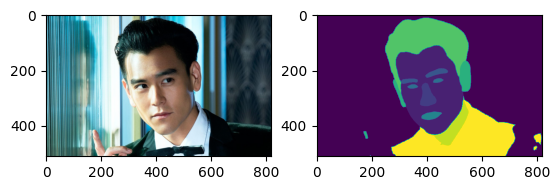

Parsing anno shape: (512, 819)


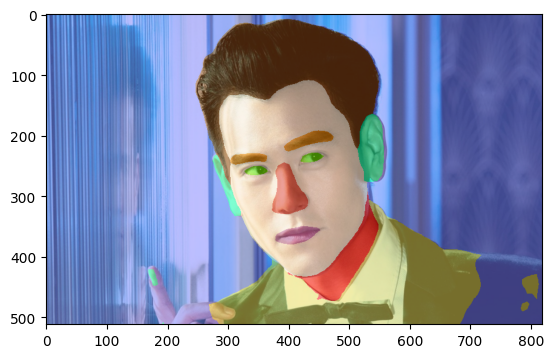

In [6]:
dspth_dict = {
        1: '/home/ishan/Bisenetv1/test-img',
        2: '/home/ishan/Bisenetv1/test-img/validation'
    }
respth_dict = {
    1: '/home/ishan/Bisenetv1/res/test_res/25082023',
    2: '/home/ishan/Bisenetv1/res/test_res/latest_val'

}
cp_dict = {
        1: '/home/ishan/Bisenetv1/res/model_best_v1.pth',
        2: '/home/ishan/Bisenetv1/res/model_best_v2.pth',
        3: '/home/ishan/Bisenetv1/res/model_final_25082023_1045.pth',
        4: '/home/ishan/Bisenetv1/res/model_final_25082023_fs_v1.pth',
        5: '/home/ishan/Bisenetv1/res/model_final_25082023_fs_v2.pth',
        6: '/home/ishan/Bisenetv1/res/terminal_test/28082023_terminal_test_v3.pth',
        7: '/home/ishan/Bisenetv1/res/terminal_test/28082023_terminal_test_v5_0.pth',
        8: '/home/ishan/Bisenetv1/res/terminal_test/28082023_terminal_test_v6/30.pth'
        }

# Select respth, dspth and image
respth=respth_dict[2]
dspth=dspth_dict[2]
cp=cp_dict[2]

image_dict = {
    1: '/home/ishan/Bisenetv1/test-img/10.jpg',
    2: '/home/ishan/Bisenetv1/test-img/10_cropped.jpg',
    3: '/home/ishan/Bisenetv1/test-img/10_og_square.jpg',
    4: '/home/ishan/Bisenetv1/test-img/10_square.jpg',
    5: '/home/ishan/Bisenetv1/test-img/p_22bb8ec2.jpg',
    6 : '/home/ishan/Bisenetv1/test-img/p_22bb8ec2_square.jpg'

}
image_path = image_dict[2]

if not os.path.exists(respth):
    os.makedirs(respth)

n_classes = 19
net = BiSeNet(n_classes=n_classes)
net.cuda()
model_save_pth = osp.join('res/cp', cp)
net.load_state_dict(torch.load(model_save_pth))
net.eval()

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),           # celebhq  
    transforms.Normalize((0.4207, 0.3943, 0.3677), (0.2562, 0.2576, 0.2705))    # fs v2
    # transforms.Normalize((0.3677, 0.3943, 0.4207), (0.2705, 0.2576, 0.2562))    # fs v1
])
with torch.no_grad():
    img = Image.open(osp.join(dspth, image_path))
    image = img  # img.resize((512, 512), Image.BILINEAR)
    
    min_dim = 512  # Minimum dimension we want to scale to

    width, height = image.size
    # Calculate the scale factor
    scale = min_dim / min(width, height)  
    # Get the new width and height
    new_width = int(width * scale)  
    new_height = int(height * scale)  
    # Resize image maintaining aspect ratio
    image = image.resize((new_width, new_height))
    
    img = to_tensor(image)
    img = torch.unsqueeze(img, 0)
    img = img.cuda()
    out = net(img)[0]
    parsing = out.squeeze(0).cpu().numpy().argmax(0)
    # print(parsing)
    # print(parsing.shape)
    print(np.unique(parsing))
    print(osp.join(respth, image_path))

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image)
    ax[1].imshow(parsing)
    plt.show()


    vis_parsing_maps(image, parsing, stride=1,
                        save_im=True, save_path=osp.join(respth, image_path))

### Experimenting with face detection and cropping for better results

515 372 709 (161, 18) (869, 726)


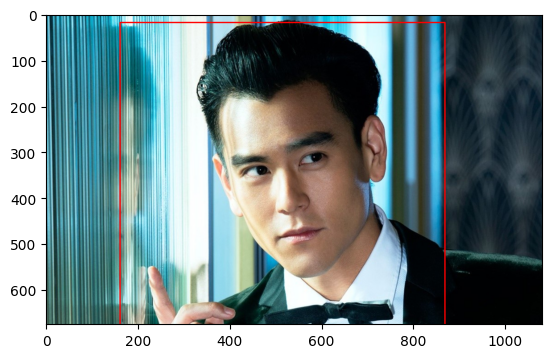

In [4]:
img = cv2.imread(image_path) 
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img)

img_with_bbox = img.copy()
# Draw rectangle around each face 
for (x, y, w, h) in faces:
  # Get center point
  c_x = x + w//2
  c_y = y + h//2  

  # Calculate side of square box  
  s = max(w+350,h+350)  

  # Draw bounding box  
  cv2.rectangle(img_with_bbox, (c_x-s//2, c_y-s//2), (c_x+s//2, c_y+s//2), (0,0,255), 2)
  print(c_x, c_y, s,(c_x-s//2, c_y-s//2), (c_x+s//2, c_y+s//2) )

plt.imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_RGB2BGR))